In [92]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer

import warnings
warnings.filterwarnings('ignore')

test_df = pd.read_csv(r'..//data//test.csv')
train_df = pd.read_csv(r'..//data//train.csv')
train_extra_df = pd.read_csv(r'..//data//training_extra.csv')
train_df_additional = pd.read_csv(r'..//data//Noisy_Student_Bag_Price_Prediction_Dataset.csv')

# # Define the mapping for Size conversion
# size_mapping = {"Small": 0, "Medium": 1, "Large": 2}

# # Convert the Size column using the mapping
# train_df["Size"] = train_df["Size"].map(size_mapping)
# test_df["Size"] = test_df["Size"].map(size_mapping)

In [96]:
len(train_extra_df)

3694318

In [94]:
# Define the columns we will use.
cat_cols = ['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
num_cols = ['Weight Capacity (kg)']

In [86]:
# --- Prepare Data ---
# Concatenate the datasets and drop the 'Price' column.
# data = pd.concat([train_df, train_df_additional], ignore_index=True).drop('Price', axis=1)
data = pd.concat([train_df, train_df_additional], ignore_index=True)



# Select only the columns we will process.
X = data[cat_cols + num_cols]

# Create the target variable: 0 for train_df, 1 for train_df_additional.
y = np.concatenate([np.zeros(len(train_df)), np.ones(len(train_df_additional))])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('to_string', FunctionTransformer(lambda x: x.astype(str))),
    ('encoder', OrdinalEncoder())
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cat_cols),
    ('num', num_pipeline, num_cols)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=0))
])

cv_preds = cross_val_predict(pipeline, X, y, cv=5, n_jobs=-1, method='predict_proba')
roc_auc = roc_auc_score(y, cv_preds[:, 1])
print(f"ROC-AUC score: {roc_auc:.3f}")

ROC-AUC score: 0.620


In [95]:
# --- Prepare Data ---
# Concatenate the datasets and drop the 'Price' column.
# data = pd.concat([train_df, train_extra_df], ignore_index=True).drop('Price', axis=1)
data = pd.concat([train_df, train_extra_df], ignore_index=True)

# Select only the columns we will process.
X = data[cat_cols + num_cols]

# Create the target variable: 0 for train_df, 1 for train_df_additional.
y = np.concatenate([np.zeros(len(train_df)), np.ones(len(train_extra_df))])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('to_string', FunctionTransformer(lambda x: x.astype(str))),
    ('encoder', OrdinalEncoder())
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cat_cols),
    ('num', num_pipeline, num_cols)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=0))
])

cv_preds = cross_val_predict(pipeline, X, y, cv=5, n_jobs=-1, method='predict_proba')
roc_auc = roc_auc_score(y, cv_preds[:, 1])
print(f"ROC-AUC score: {roc_auc:.3f}")

ROC-AUC score: 0.500


## Exploratory data analysis (EDA)
**Key insights**
* The `Price` feature is relatively evenly distributed. There are **no clear peaks or trends**, but price is slightly skewed to the lower end.
* Compartments spans evenly from 2 to 10.
* Correlation coefficients suggests that numeric features have a **minimal impact** on the `Price`.

In [44]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  float64
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 25.2+ MB


### Price
#### Key Insights:
* When binning the data into 100 bins, we can see a **large spike** in prices around **150.0** indicating that the data generation process went above this number but the final values were clipped here.
* The skew test suggests that it is **mostly symmetric** with a slight right skew.
* The mean and median are nearly the same except the **median** is **slightly less**. 
* The chisquare test suggests it **significantly deviates** from **uniformity**.

Skewness of Price: 0.0369

Mean Price: 81.41
Median Price: 80.95612

Chi-Square Statistic: 443.8082, p-value: 0.000000


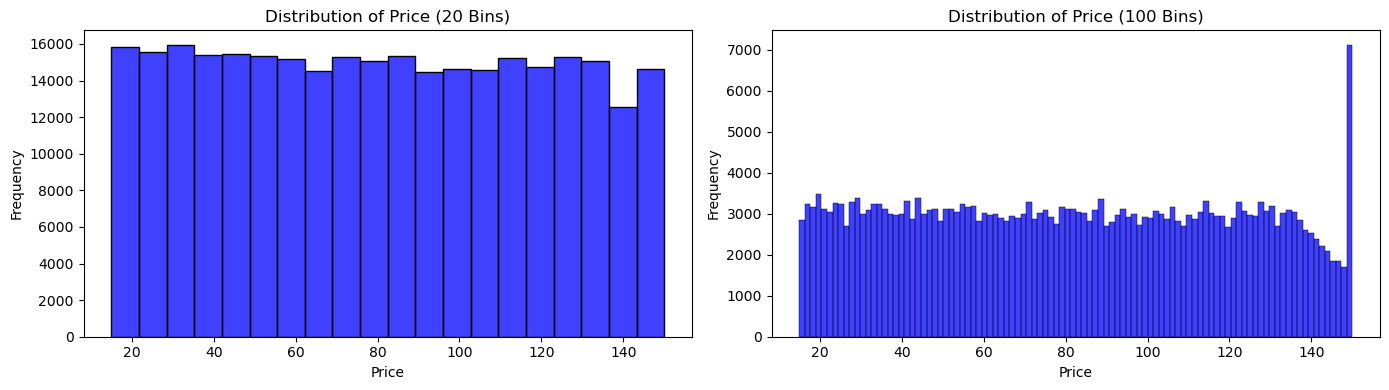

In [45]:
from scipy.stats import skew, chisquare
import numpy as np

price_skewness = skew(train_df['Price'])
print(f"Skewness of Price: {price_skewness:.4f}\n")

mean_price = train_df['Price'].mean()
median_price = train_df['Price'].median()
print(f"Mean Price: {mean_price:.2f}")
print(f"Median Price: {median_price}\n")

# Create bins for uniform comparison
price_counts, bin_edges = np.histogram(train_df['Price'], bins=10)
expected_counts = [len(train_df) / 10] * 10  # Expected counts for uniform distribution
chi_stat, p_value = chisquare(price_counts, f_exp=expected_counts)
print(f"Chi-Square Statistic: {chi_stat}, p-value: {p_value:.6f}")


fig, axes = plt.subplots(1, 2, figsize=(14, 4))  # 1 row, 2 columns

# Plot the first histogram with 20 bins
sns.histplot(train_df['Price'], bins=20, color="blue", ax=axes[0])
axes[0].set_title("Distribution of Price (20 Bins)")
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Frequency")

# Plot the second histogram with 100 bins
sns.histplot(train_df['Price'], bins=100, color="blue", ax=axes[1])
axes[1].set_title("Distribution of Price (100 Bins)")
axes[1].set_xlabel("Price")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### Numeric Feature Distributions

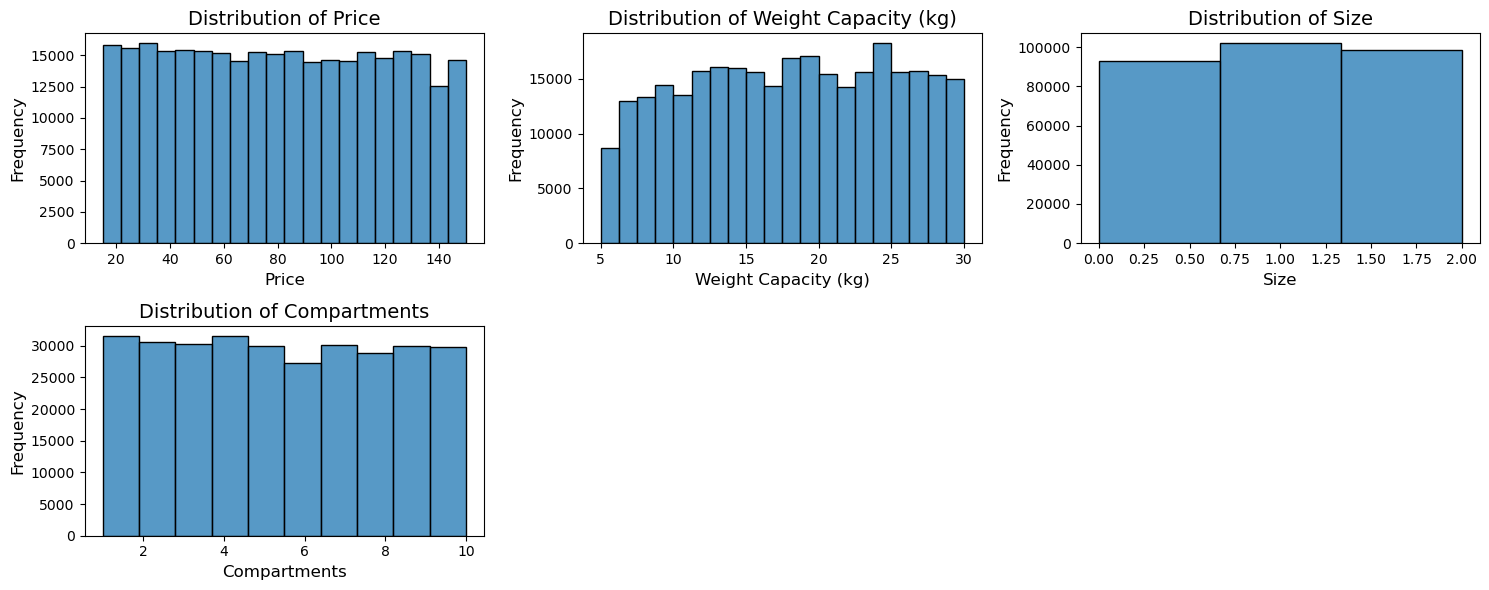

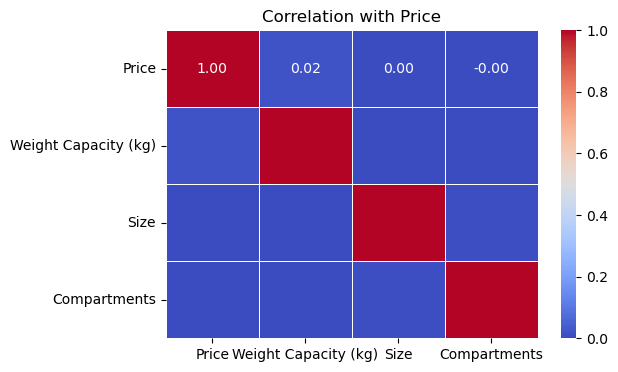

In [46]:
numeric_features = ['Price', 'Weight Capacity (kg)', 'Size', 'Compartments']

num_features = len(numeric_features)
cols = 3
rows = (num_features // cols) + (num_features % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    bins = 20 if train_df[feature].nunique() > 20 else train_df[feature].nunique()
    sns.histplot(train_df[feature], bins=bins, palette="viridis", ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}", fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel("Frequency", fontsize=12)

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Plot correlation matrix
correlation_matrix = train_df[numeric_features].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation with Price")
plt.show()

## Categorical Features

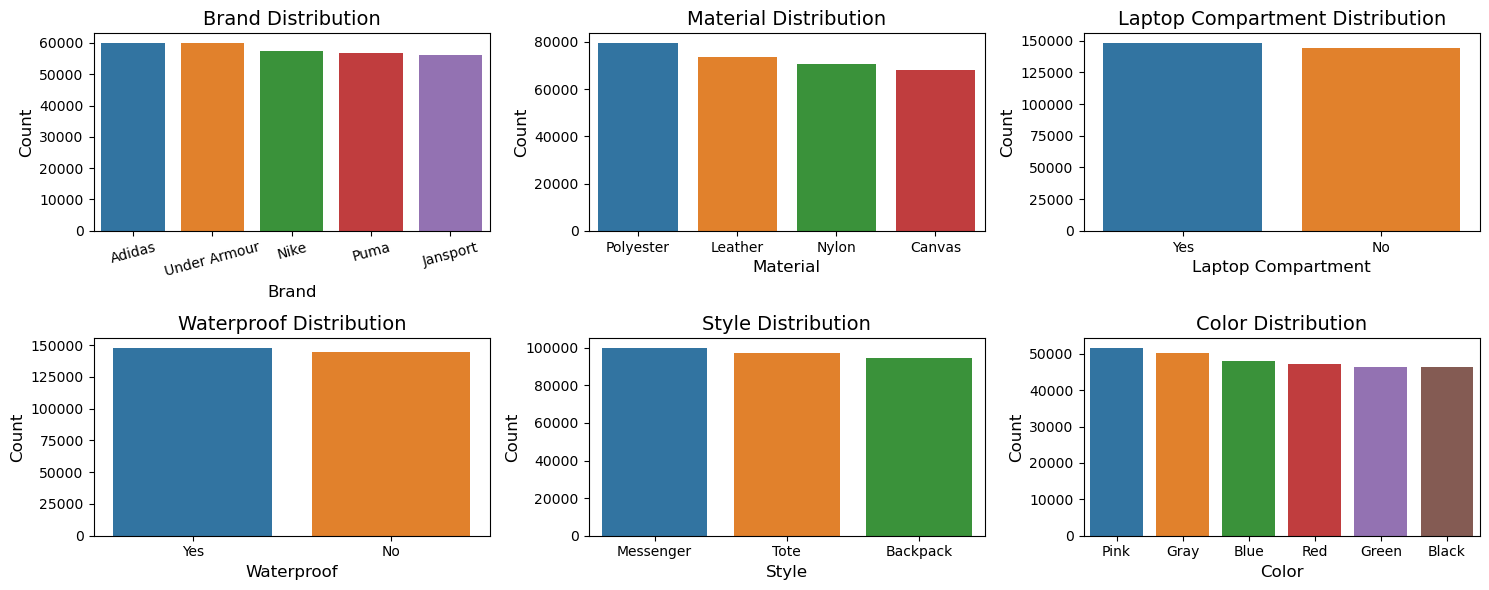

In [47]:
categorical_features = ['Brand', 'Material', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']

# Define the number of rows and columns for subplots
num_features = len(categorical_features)
cols = 3 
rows = (num_features // cols) + (num_features % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    value_counts = train_df[feature].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[i])
    axes[i].set_title(f"{feature} Distribution", fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel("Count", fontsize=12)
    if feature == 'Brand':
        axes[i].tick_params(axis='x', rotation=15)

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

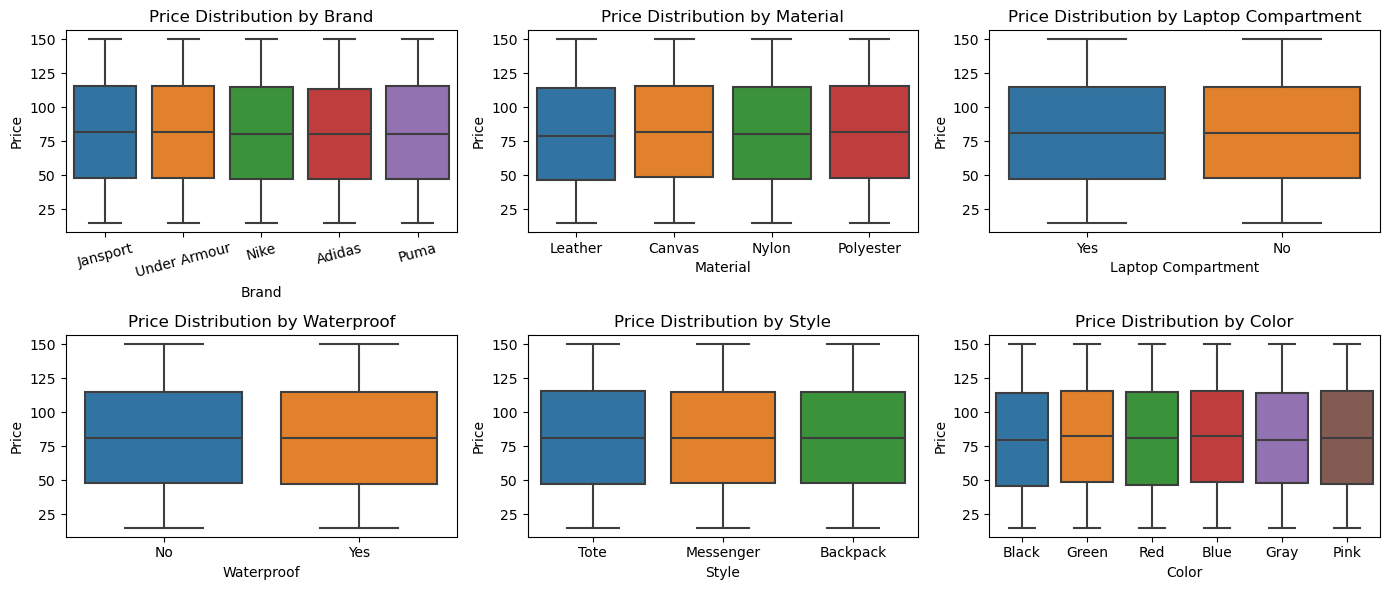

In [48]:
fig, axes = plt.subplots(rows, cols, figsize=(14, 3 * rows))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.boxplot(x=train_df[feature], y=train_df['Price'], ax=axes[i])
    axes[i].set_title(f"Price Distribution by {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Price")
    if feature == 'Brand':
        axes[i].tick_params(axis='x', rotation=15)
        
# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Modeling

In [49]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

target = "Price"
X = train_df.drop(columns=[target])
y = train_df[target]

# Number of folds for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
rmse_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X):
    # Split data into training and testing folds
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Predict the median of the training target
    median_prediction = np.median(y_train)
    y_pred = np.full_like(y_test, fill_value=median_prediction, dtype=np.float64)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

# Calculate mean and standard deviation of RMSE
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

# Print the results
print(f"Baseline Median Model - RMSE Scores: {rmse_scores}")
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Standard Deviation of RMSE: {std_rmse:.4f}")

Baseline Median Model - RMSE Scores: [38.944393283526324, 39.080557096741394, 39.04686686483414, 39.10403208479137, 39.03611566776156]
Mean RMSE: 39.0424
Standard Deviation of RMSE: 0.0546


In [50]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error

# import lightgbm as lgb
# from sklearn.ensemble import RandomForestRegressor

# # Assume train_df is already defined and contains a column "Price"
# target = "Price"
# X = train_df.drop(columns=[target])
# cat_cols = X.select_dtypes(include=['object']).columns.tolist()
# X[cat_cols] = X[cat_cols].astype("category")

# y = train_df[target]

# # Set up cross-validation
# n_splits = 5
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# # Define the models to test
# models = {
#     "Median": None,  # Baseline: predict the median of the training target
#     "RandomForest": RandomForestRegressor(random_state=42),
#     "LightGBM": lgb.LGBMRegressor(random_state=42),
# }

# # Dictionary to store RMSE scores for each model
# model_scores = {name: [] for name in models.keys()}

# # Begin cross-validation
# for train_index, test_index in kf.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     for name, model in models.items():
#         if name == "Median":
#             # Baseline prediction using the median of y_train
#             median_prediction = np.median(y_train)
#             y_pred = np.full_like(y_test, fill_value=median_prediction, dtype=np.float64)
#         else:
#             # Train the model on the current fold and predict
#             model.fit(X_train, y_train)
#             y_pred = model.predict(X_test)
        
#         # Calculate RMSE and store it
#         rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#         model_scores[name].append(rmse)

# # Print the cross-validation results for each model
# for name, scores in model_scores.items():
#     mean_rmse = np.mean(scores)
#     std_rmse = np.std(scores)
#     print(f"{name} Model - RMSE Scores: {scores}")
#     print(f"Mean RMSE: {mean_rmse:.4f}")
#     print(f"Standard Deviation of RMSE: {std_rmse:.4f}")
#     print("-" * 50)

In [63]:
import time
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.compose import ColumnTransformer
import lightgbm as lgb

target = "Price"
X = train_df.drop(columns=[target])
y = train_df[target]

# Identify numerical and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create preprocessor
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

# Set up cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the models to test
models = {
    "Median": None,  # Baseline: predict the median of the training target
    "LightGBM": lgb.LGBMRegressor(verbosity=-1, random_state=42),
    # "RandomForest": RandomForestRegressor(n_jobs=-1, random_state=42),
}

# Dictionary to store RMSE scores for each model
model_scores = {name: [] for name in models.keys()}

# Begin cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    print(f"Starting Fold {fold}...")
    fold_start_time = time.time()

    # Split the data into training and testing folds
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the preprocessor on the training data and transform both training and test data
    preprocess_start_time = time.time()
    X_train_enc = preprocessor.fit_transform(X_train)
    X_test_enc = preprocessor.transform(X_test)
    print(f"Preprocessing time: {time.time() - preprocess_start_time:.2f} seconds")


    for name, model in models.items():
        model_start_time = time.time()

        if name == "Median":
            # Baseline prediction: use the median of y_train
            median_prediction = np.median(y_train)
            y_pred = np.full_like(y_test, fill_value=median_prediction, dtype=np.float64)
        else:
            # Train the model on the preprocessed training data and predict on the preprocessed test data
            model.fit(X_train_enc, y_train)
            y_pred = model.predict(X_test_enc)
        
        # Calculate RMSE for the current fold
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        model_scores[name].append(rmse)
        print(f"{name} Model - Fold {fold} - Training & Prediction time: {time.time() - model_start_time:.2f} seconds")

    print(f"Total time for Fold {fold}: {time.time() - fold_start_time:.2f} seconds")
    print("-" * 50)

# Print the cross-validation results for each model
for name, scores in model_scores.items():
    mean_rmse = np.mean(scores)
    std_rmse = np.std(scores)
    print(f"{name} Model - RMSE Scores: {scores}")
    print(f"Mean RMSE: {mean_rmse:.4f}")
    print(f"Standard Deviation of RMSE: {std_rmse:.4f}")
    print("-" * 50)

Starting Fold 1...
Preprocessing time: 0.39 seconds
Median Model - Fold 1 - Training & Prediction time: 0.00 seconds
LightGBM Model - Fold 1 - Training & Prediction time: 0.59 seconds
Total time for Fold 1: 1.00 seconds
--------------------------------------------------
Starting Fold 2...
Preprocessing time: 0.40 seconds
Median Model - Fold 2 - Training & Prediction time: 0.00 seconds
LightGBM Model - Fold 2 - Training & Prediction time: 0.58 seconds
Total time for Fold 2: 1.01 seconds
--------------------------------------------------
Starting Fold 3...
Preprocessing time: 0.40 seconds
Median Model - Fold 3 - Training & Prediction time: 0.00 seconds
LightGBM Model - Fold 3 - Training & Prediction time: 0.62 seconds
Total time for Fold 3: 1.05 seconds
--------------------------------------------------
Starting Fold 4...
Preprocessing time: 0.41 seconds
Median Model - Fold 4 - Training & Prediction time: 0.01 seconds
LightGBM Model - Fold 4 - Training & Prediction time: 0.58 seconds
Tot

In [52]:
train_df.Size.value_counts()

Size
1.0    101906
2.0     98643
0.0     92856
Name: count, dtype: int64

In [53]:
np.abs(y_test - y_pred).sort_values()

88310      0.001105
159912     0.007669
50859      0.009179
99749      0.009278
35608      0.009453
            ...    
370       76.741321
83165     77.533361
218164    77.728770
138294    78.975394
200912    80.273873
Name: Price, Length: 60000, dtype: float64

In [54]:
train_df.iloc[147186]

id                            147186
Brand                   Under Armour
Material                     Leather
Size                             NaN
Compartments                     9.0
Laptop Compartment                No
Waterproof                       Yes
Style                      Messenger
Color                           Gray
Weight Capacity (kg)             5.0
Price                      149.08665
Name: 147186, dtype: object

## Nearest Neighbors

In [55]:
# Apply transformations
X = preprocessor.fit_transform(train_df)

# Perform clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
train_df['Cluster'] = kmeans.fit_predict(X)

# Find the closest points using Nearest Neighbors
nbrs = NearestNeighbors(n_neighbors=5, metric='euclidean').fit(X)
index = 147186  # Index of the reference data point
query_point = X[index].reshape(1, -1)
distances, indices = nbrs.kneighbors(query_point)

# Retrieve similar data points
similar_points = train_df.iloc[indices[0]]
similar_points

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,Cluster
147186,147186,Under Armour,Leather,NaN,9.0,No,Yes,Messenger,Gray,5.000000,149.08665,0
209388,209388,Under Armour,Leather,1.0,10.0,No,Yes,Messenger,Gray,8.097117,56.61884,0
48876,48876,Under Armour,Leather,1.0,10.0,No,Yes,Messenger,Gray,6.884462,47.13132,2
171486,171486,Under Armour,Leather,1.0,7.0,No,Yes,Messenger,Gray,11.946509,117.63063,0
115579,115579,Under Armour,Leather,2.0,10.0,No,Yes,Messenger,Gray,7.293163,61.78912,2


In [56]:
train_df[train_df[num_cols+cat_cols].duplicated()].sort_values(by=num_cols+cat_cols).head(20)

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,Cluster


In [39]:
cat_cols

['Brand', 'Material', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']

In [59]:
train_df[train_df.duplicated(subset=cat_cols)].sort_values(by=cat_cols).head(20)

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,Cluster
4428,4428,Adidas,Canvas,0.0,4.0,No,No,Backpack,Black,20.380124,96.23904,3
5056,5056,Adidas,Canvas,NaN,5.0,No,No,Backpack,Black,28.957133,33.03963,3
11764,11764,Adidas,Canvas,1.0,4.0,No,No,Backpack,Black,11.771375,114.20979,1
11888,11888,Adidas,Canvas,2.0,6.0,No,No,Backpack,Black,15.275616,31.20914,2
15838,15838,Adidas,Canvas,1.0,9.0,No,No,Backpack,Black,13.465853,120.17279,2
17221,17221,Adidas,Canvas,1.0,8.0,No,No,Backpack,Black,20.796103,51.03968,2
17457,17457,Adidas,Canvas,2.0,4.0,No,No,Backpack,Black,5.613985,100.04614,1
21038,21038,Adidas,Canvas,0.0,2.0,No,No,Backpack,Black,28.992886,77.24810,3
25070,25070,Adidas,Canvas,0.0,7.0,No,No,Backpack,Black,10.668149,130.96059,0
30175,30175,Adidas,Canvas,2.0,3.0,No,No,Backpack,Black,5.232215,20.85207,1


In [65]:
import optuna
import lightgbm as lgb
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score

# 1. Generate a synthetic regression dataset
# X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)

# 2. Define the objective function for Optuna
def objective(trial):
    # Define hyperparameter search space
    param = {
        # General parameters
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'random_state': 42,
        # Hyperparameters to tune
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        # You can also tune additional parameters if desired:
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    
    # Initialize the model with these parameters
    model = lgb.LGBMRegressor(**param)
    
    # Evaluate model performance using 3-fold cross-validation
    # We use negative MSE, then take the square root to get RMSE
    cv_scores = cross_val_score(model, X_train_enc, y_train, 
                                scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
    rmse = np.sqrt(-cv_scores.mean())
    return rmse

# 3. Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print("Best trial:")
best_trial = study.best_trial
print("  RMSE: {:.4f}".format(best_trial.value))
print("  Best hyperparameters: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-02-02 13:30:24,223] A new study created in memory with name: no-name-58053a4e-9a72-412c-8038-d6bb26075ba1
[I 2025-02-02 13:30:43,876] Trial 0 finished with value: 39.04391252286817 and parameters: {'num_leaves': 54, 'max_depth': 6, 'learning_rate': 0.006290013661256006, 'n_estimators': 824, 'min_child_samples': 16, 'subsample': 0.8397509386462776, 'colsample_bytree': 0.7452725439645947}. Best is trial 0 with value: 39.04391252286817.
[I 2025-02-02 13:30:51,176] Trial 1 finished with value: 39.03800745483694 and parameters: {'num_leaves': 82, 'max_depth': 10, 'learning_rate': 0.016956774715926028, 'n_estimators': 166, 'min_child_samples': 63, 'subsample': 0.6760354844882481, 'colsample_bytree': 0.5426738833065787}. Best is trial 1 with value: 39.03800745483694.
[I 2025-02-02 13:31:25,879] Trial 2 finished with value: 39.04297299374068 and parameters: {'num_leaves': 73, 'max_depth': 10, 'learning_rate': 0.0024581694816950754, 'n_estimators': 912, 'min_child_samples': 61, 'subsamp

Best trial:
  RMSE: 39.0380
  Best hyperparameters: 
    num_leaves: 82
    max_depth: 10
    learning_rate: 0.016956774715926028
    n_estimators: 166
    min_child_samples: 63
    subsample: 0.6760354844882481
    colsample_bytree: 0.5426738833065787


In [69]:
def objective(trial):
    # Select boosting type: try both traditional gbdt and dart (which randomly drops trees)
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart'])
    
    # Define the hyperparameter search space
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': boosting_type,
        'num_leaves': trial.suggest_int('num_leaves', 200, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),
        # Allow a high number of iterations since we use early stopping
        'n_estimators': trial.suggest_int('n_estimators', 100, 5000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 200),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'max_bin': trial.suggest_int('max_bin', 100, 500),  # recommendation: use large max_bin
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'verbosity': -1,
        'random_state': 42,
        'early_stopping_rounds': 50,

    }
    
    # For the DART boosting type, include dart‑specific parameters.
    if boosting_type == 'dart':
        param['drop_rate'] = trial.suggest_float('drop_rate', 0.0, 0.5)
    
    # Initialize the model with these parameters
    model = lgb.LGBMRegressor(**param)
    cv = KFold(n_splits=2, shuffle=True, random_state=42)
    rmse_scores = []
    
    for train_idx, valid_idx in cv.split(X_train_enc):
        X_tr, X_val = X_train_enc[train_idx], X_train_enc[valid_idx]
        # If y_train is a pandas Series, use .iloc for indexing
        if isinstance(y_train, pd.Series):
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        else:
            y_tr, y_val = y_train[train_idx], y_train[valid_idx]
        
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
        )
        preds = model.predict(X_val)
        fold_rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmse_scores.append(fold_rmse)
    
    return np.mean(rmse_scores)

# ================================
# 3. Optimize Hyperparameters with Optuna
# ================================

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best trial:")
best_trial = study.best_trial
print("  RMSE: {:.4f}".format(best_trial.value))
print("  Best hyperparameters:")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

# ================================
# 4. Train Final Model Using the Best Hyperparameters
# ================================

# Copy the best parameters and add constant ones
best_params = best_trial.params.copy()
best_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'random_state': 42,
    'verbosity': -1
})

# Initialize and train the final model on the full training set
final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(X_train_enc, y_train)

# Evaluate on the test set
y_pred = final_model.predict(X_test_enc)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Final Test RMSE: {:.4f}".format(final_rmse))

[I 2025-02-02 14:11:11,442] A new study created in memory with name: no-name-e488ffe0-0408-4c3a-993d-f64fc6a8bcc0
[I 2025-02-02 14:11:14,974] Trial 0 finished with value: 39.037688042938086 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 300, 'max_depth': 4, 'learning_rate': 0.010893807998866557, 'n_estimators': 1256, 'min_child_samples': 144, 'subsample': 0.6116373487174114, 'colsample_bytree': 0.5220182279562005, 'max_bin': 100, 'reg_alpha': 1.928625989364237, 'reg_lambda': 2.9294864365688814e-05, 'min_split_gain': 0.4741215513650401}. Best is trial 0 with value: 39.037688042938086.
[I 2025-02-02 14:11:29,016] Trial 1 finished with value: 39.040500149117634 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 110, 'max_depth': 18, 'learning_rate': 0.0026246021306864844, 'n_estimators': 1812, 'min_child_samples': 38, 'subsample': 0.8714973313845984, 'colsample_bytree': 0.5019667724852972, 'max_bin': 230, 'reg_alpha': 0.9788961205842874, 'reg_lambda': 0.32492908034923734, 'm

Best trial:
  RMSE: 39.0352
  Best hyperparameters:
    boosting_type: gbdt
    num_leaves: 256
    max_depth: 3
    learning_rate: 0.004509104775809521
    n_estimators: 1312
    min_child_samples: 85
    subsample: 0.6546559213149051
    colsample_bytree: 0.5008446769889494
    max_bin: 495
    reg_alpha: 0.02582766894019649
    reg_lambda: 3.421542329015424e-07
    min_split_gain: 0.3198124843507867
Final Test RMSE: 38.9123


In [72]:
study.trials_dataframe().sort_values(by='value')

,number,value,datetime_start,datetime_complete,duration,params_boosting_type,params_colsample_bytree,params_drop_rate,params_learning_rate,params_max_bin,params_max_depth,params_min_child_samples,params_min_split_gain,params_n_estimators,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample,state
13,13,39.035218,2025-02-02 16:49:46.714584,2025-02-02 16:49:53.257012,0 days 00:00:06.542428,gbdt,0.500845,NaN,0.004509,495,3,85,0.319812,1312,256,2.582767e-02,3.421542e-07,0.654656,COMPLETE
27,27,39.036428,2025-02-02 16:51:25.440007,2025-02-02 16:51:36.903660,0 days 00:00:11.463653,gbdt,0.505725,NaN,0.002295,336,3,20,0.715013,2795,242,1.314047e-02,5.906241e-03,0.567549,COMPLETE
33,33,39.036697,2025-02-02 16:52:44.159039,2025-02-02 16:52:52.992201,0 days 00:00:08.833162,gbdt,0.570456,NaN,0.002249,248,3,28,0.548844,1635,208,4.657334e-01,2.133086e-01,0.548555,COMPLETE
12,12,39.036769,2025-02-02 16:49:40.358724,2025-02-02 16:49:46.713986,0 days 00:00:06.355262,gbdt,0.518603,NaN,0.004977,350,3,160,0.706009,1320,231,1.679902e-02,1.123393e-06,0.982919,COMPLETE
43,43,39.037114,2025-02-02 17:15:18.411452,2025-02-02 17:15:29.680451,0 days 00:00:11.268999,gbdt,0.526073,NaN,0.002435,122,4,85,0.625317,2171,232,4.714309e-01,1.505346e-06,0.855588,COMPLETE
32,32,39.037114,2025-02-02 16:52:34.933015,2025-02-02 16:52:44.158281,0 days 00:00:09.225266,gbdt,0.532757,NaN,0.002253,244,3,77,0.544664,1668,272,3.420346e-03,4.213108e-05,0.599868,COMPLETE
21,21,39.037142,2025-02-02 16:50:56.956384,2025-02-02 16:51:01.559461,0 days 00:00:04.603077,gbdt,0.532950,NaN,0.008044,214,5,102,0.425566,1382,293,3.167085e-03,2.448385e-05,0.620187,COMPLETE
44,44,39.037302,2025-02-02 17:15:29.681206,2025-02-02 17:15:31.965370,0 days 00:00:02.284164,gbdt,0.516882,NaN,0.015408,130,4,124,0.647205,2148,207,3.804624e-01,8.152216e+00,0.867866,COMPLETE
41,41,39.037538,2025-02-02 17:15:00.508477,2025-02-02 17:15:08.801106,0 days 00:00:08.292629,gbdt,0.521315,NaN,0.001888,246,3,76,0.552532,1624,271,1.728883e-03,1.883093e-03,0.601756,COMPLETE
45,45,39.037577,2025-02-02 17:15:31.966032,2025-02-02 17:15:39.328851,0 days 00:00:07.362819,gbdt,0.585972,NaN,0.003147,107,4,158,0.790038,3319,231,7.916297e-01,1.439693e-06,0.913421,COMPLETE


In [73]:
def objective(trial):
    # Select boosting type: try both traditional gbdt and dart (which randomly drops trees)
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart'])
    
    # Define the hyperparameter search space
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': boosting_type,
        'num_leaves': trial.suggest_int('num_leaves', 200, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.5),
        # Allow a high number of iterations since we use early stopping
        'n_estimators': trial.suggest_int('n_estimators', 50, 5000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 200),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.25, 1.0),
        'max_bin': trial.suggest_int('max_bin', 50, 1000),  # recommendation: use large max_bin
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.1, 1.0),
        'verbosity': -1,
        'random_state': 42,
        'early_stopping_rounds': 50,

    }
    
    # For the DART boosting type, include dart‑specific parameters.
    if boosting_type == 'dart':
        param['drop_rate'] = trial.suggest_float('drop_rate', 0.0, 0.5)
    
    # Initialize the model with these parameters
    model = lgb.LGBMRegressor(**param)
    cv = KFold(n_splits=2, shuffle=True, random_state=42)
    rmse_scores = []
    
    for train_idx, valid_idx in cv.split(X_train_enc):
        X_tr, X_val = X_train_enc[train_idx], X_train_enc[valid_idx]
        # If y_train is a pandas Series, use .iloc for indexing
        if isinstance(y_train, pd.Series):
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        else:
            y_tr, y_val = y_train[train_idx], y_train[valid_idx]
        
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
        )
        preds = model.predict(X_val)
        fold_rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmse_scores.append(fold_rmse)
    
    return np.mean(rmse_scores)


study_2 = optuna.create_study(direction='minimize')
study_2.optimize(objective, n_trials=100)

print("Best trial:")
best_trial = study_2.best_trial
print("  RMSE: {:.4f}".format(best_trial.value))
print("  Best hyperparameters:")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))


[I 2025-02-02 17:51:33,513] A new study created in memory with name: no-name-98d829ce-efd8-430e-9f18-bdc4caf74e26
[I 2025-02-02 18:03:06,945] Trial 0 finished with value: 39.35432410328873 and parameters: {'boosting_type': 'dart', 'num_leaves': 478, 'max_depth': 7, 'learning_rate': 0.05869192788807354, 'n_estimators': 2807, 'min_child_samples': 191, 'subsample': 0.6003920780066684, 'colsample_bytree': 0.8764416612260452, 'max_bin': 215, 'reg_alpha': 6.65296755946704e-08, 'reg_lambda': 5.696935449154001e-05, 'min_split_gain': 0.31441295266950736, 'drop_rate': 0.38908022089367456}. Best is trial 0 with value: 39.35432410328873.
[I 2025-02-02 18:04:43,943] Trial 1 finished with value: 39.11967936314256 and parameters: {'boosting_type': 'dart', 'num_leaves': 717, 'max_depth': 4, 'learning_rate': 0.04258753717514883, 'n_estimators': 951, 'min_child_samples': 86, 'subsample': 0.9263669487289782, 'colsample_bytree': 0.7243681484839162, 'max_bin': 938, 'reg_alpha': 1.2949102851191977e-05, 'reg

Best trial:
  RMSE: 39.0338
  Best hyperparameters:
    boosting_type: gbdt
    num_leaves: 797
    max_depth: 2
    learning_rate: 0.23222786680269508
    n_estimators: 3680
    min_child_samples: 125
    subsample: 0.4318364370624094
    colsample_bytree: 0.40293728188317085
    max_bin: 115
    reg_alpha: 8.100399352674858
    reg_lambda: 0.053377621988250634
    min_split_gain: 0.6568499304653787


In [ ]:
study_2.trials_dataframe().sort_values(by='value')